# Preprocessing Data

In [25]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
import xgboost as xgb
import optuna


In [26]:
'''# Download the .zip file
url = 'https://archive.ics.uci.edu/static/public/296/diabetes+130-us+hospitals+for+years+1999-2008.zip' 
r = requests.get(url)
with open('datasets.zip', 'wb') as f:
    f.write(r.content)

# Extract the diabetic dataset
with zipfile.ZipFile('datasets.zip', 'r') as zip_ref:
    desired_file = 'diabetic_data.csv'  
    zip_ref.extract(desired_file)

# Read the dataset into a DataFrame
df = pd.read_csv(desired_file)

# Print the DataFrame to verify
print(df)

# Optional: Delete the downloaded files
# os.remove('datasets.zip')
# os.remove(desired_file)
'''

"# Download the .zip file\nurl = 'https://archive.ics.uci.edu/static/public/296/diabetes+130-us+hospitals+for+years+1999-2008.zip' \nr = requests.get(url)\nwith open('datasets.zip', 'wb') as f:\n    f.write(r.content)\n\n# Extract the diabetic dataset\nwith zipfile.ZipFile('datasets.zip', 'r') as zip_ref:\n    desired_file = 'diabetic_data.csv'  \n    zip_ref.extract(desired_file)\n\n# Read the dataset into a DataFrame\ndf = pd.read_csv(desired_file)\n\n# Print the DataFrame to verify\nprint(df)\n\n# Optional: Delete the downloaded files\n# os.remove('datasets.zip')\n# os.remove(desired_file)\n"

In [27]:
# Read the file
workdir = os.getcwd()  # Get the current working directory
file_path = os.path.join(workdir, './dataset/diabetic_data.csv')  # Join the workdir and filename

original_df = pd.read_csv(file_path)

df = original_df.copy(deep=True)

In [28]:
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [29]:
df['weight'].unique()

array(['?', '[75-100)', '[50-75)', '[0-25)', '[100-125)', '[25-50)',
       '[125-150)', '[175-200)', '[150-175)', '>200'], dtype=object)

In [30]:
# Function to count the repetitions of each value in a column
def count_values(df, column):
  """Counts the repetitions of each value in a column of a DataFrame.

  Args:
    df: A Pandas DataFrame.
    column: The name of the column to analyze.

  Returns:
    A Series with the values as index and their repetitions as values.
  """
  repetitions = df[column].value_counts()
  return repetitions


repetitions = count_values(df, "weight")

print(repetitions)


?            98569
[75-100)      1336
[50-75)        897
[100-125)      625
[125-150)      145
[25-50)         97
[0-25)          48
[150-175)       35
[175-200)       11
>200             3
Name: weight, dtype: int64


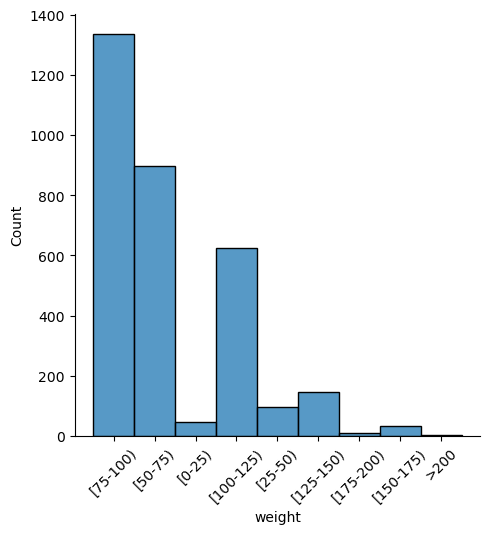

In [31]:
# Function to plot the distribution of a column
def plot_distribution(column, df):
  """Plots the distribution of a specific column from a DataFrame.

  Args:
    column: The name of the column to plot.
    df: The pandas DataFrame containing the data.

  Returns:
    None. The function directly displays the plot.
  """

  data = df[df[column] != "?"]  # Filter out rows with "?" in the column
  sns.displot(data[column], kind="hist")  # Create the distribution plot
  plt.xticks(rotation=45)  # Rotate x-labels by 45 degrees
  plt.show()  # Display the plot

plot_distribution('weight',df)


In [32]:
# Drop features
def drop_features(df):

    df = df.drop(['weight', 'payer_code', 'medical_specialty', 'examide', 'citoglipton'], axis=1)

    # drop bad data with 3 '?' in diag
    drop_ID = set(df[(df['diag_1'] == '?') & (df['diag_2'] == '?') & (df['diag_3'] == '?')].index)

    # drop died patient data which 'discharge_disposition_id' == 11 | 19 | 20 | 21 indicates 'Expired'
    drop_ID = drop_ID.union(set(df[(df['discharge_disposition_id'] == 11) | (df['discharge_disposition_id'] == 19) | \
                                (df['discharge_disposition_id'] == 20) | (df['discharge_disposition_id'] == 21)].index))

    # drop 3 data with 'Unknown/Invalid' gender
    drop_ID = drop_ID.union(df['gender'][df['gender'] == 'Unknown/Invalid'].index)

    # create a set of indexes to drop the IDs that are not required
    new_ID = list(set(df.index) - set(drop_ID))

    df = df.iloc[new_ID]

    return df

df = drop_features(df)

In [33]:
"""# Encode data

def encode(df):
    df['readmitted'] = df['readmitted'].replace({'>30': 1, '<30': 1, 'NO': 0}) # Encode readmitted column
    df['race'] = df['race'].replace({'Asian':0, 'AfricanAmerican':1, 'Caucasian': 2, 'Hispanic': 3, 'Other': 4, '?': 4})# Encode race column
    df['A1Cresult'] = df['A1Cresult'].replace({'None': -99, '>8': 1, '>7': 1, 'Norm': 0})# Encode A1Cresult column
    df['max_glu_serum'] = df['max_glu_serum'].replace({'>200': 1, '>300': 1, 'Norm': 0, 'None': -99})# Encode max_glu_serum column
    df['change'] = df['change'].replace({'No': 0, 'Ch': 1})# Encode change column
    df['gender'] = df['gender'].replace({'Male': 1, 'Female': 0})# Encode gender column
    df['diabetesMed'] = df['diabetesMed'].replace({'Yes': 1, 'No':0})# Encode diabetesMed column
    # Encode age column
    age_dict = {'[0-10)': 5, '[10-20)': 15, '[20-30)': 25, '[30-40)': 35, '[40-50)': 45, '[50-60)': 55, '[60-70)': 65,
            '[70-80)': 75, '[80-90)': 85, '[90-100)': 95}
    df['age'] = df['age'].replace(age_dict)
    df['age'] = df['age'].astype('int64')
    return df

df = encode(df)"""

"# Encode data\n\ndef encode(df):\n    df['readmitted'] = df['readmitted'].replace({'>30': 1, '<30': 1, 'NO': 0}) # Encode readmitted column\n    df['race'] = df['race'].replace({'Asian':0, 'AfricanAmerican':1, 'Caucasian': 2, 'Hispanic': 3, 'Other': 4, '?': 4})# Encode race column\n    df['A1Cresult'] = df['A1Cresult'].replace({'None': -99, '>8': 1, '>7': 1, 'Norm': 0})# Encode A1Cresult column\n    df['max_glu_serum'] = df['max_glu_serum'].replace({'>200': 1, '>300': 1, 'Norm': 0, 'None': -99})# Encode max_glu_serum column\n    df['change'] = df['change'].replace({'No': 0, 'Ch': 1})# Encode change column\n    df['gender'] = df['gender'].replace({'Male': 1, 'Female': 0})# Encode gender column\n    df['diabetesMed'] = df['diabetesMed'].replace({'Yes': 1, 'No':0})# Encode diabetesMed column\n    # Encode age column\n    age_dict = {'[0-10)': 5, '[10-20)': 15, '[20-30)': 25, '[30-40)': 35, '[40-50)': 45, '[50-60)': 55, '[60-70)': 65,\n            '[70-80)': 75, '[80-90)': 85, '[90-100)':

In [34]:
# encode readmitted data

df['readmitted'] = df['readmitted'].replace({'>30': 1, '<30': 1, 'NO': 0})  

count_values(df,'readmitted')

0    53208
1    46902
Name: readmitted, dtype: int64

In [35]:
# encode race data
df['race'] = df['race'].replace({'Asian':0, 'AfricanAmerican':1, 'Caucasian': 2, 'Hispanic': 3, 'Other': 4, '?': 4})

count_values(df,'race')

2    74845
1    18888
4     3722
3     2024
0      631
Name: race, dtype: int64

In [36]:
#  encode A1Cresult
df['A1Cresult'] = df['A1Cresult'].replace({'None': -99, '>8': 1, '>7': 1, 'Norm': 0})  

count_values(df,'A1Cresult')


-99    83234
 1     11935
 0      4941
Name: A1Cresult, dtype: int64

In [37]:
# encode max_glu_serum
df['max_glu_serum'] = df['max_glu_serum'].replace({'>200': 1, '>300': 1, 'Norm': 0, 'None': -99})

count_values(df, 'max_glu_serum')

-99    94886
 1      2651
 0      2573
Name: max_glu_serum, dtype: int64

In [38]:


# encode change
df['change'] = df['change'].replace({'No': 0, 'Ch': 1})

count_values(df,'change')


0    53669
1    46441
Name: change, dtype: int64

In [39]:
# enconde gender

df['gender'] = df['gender'].replace({'Male': 1, 'Female': 0})

count_values(df,'gender')

0    53861
1    46249
Name: gender, dtype: int64

In [40]:
# encode diabetesMed
df['diabetesMed'] = df['diabetesMed'].replace({'Yes': 1, 'No':0})

count_values(df,'diabetesMed')

1    77270
0    22840
Name: diabetesMed, dtype: int64

In [41]:
# encode age

age_dict = {'[0-10)': 5, '[10-20)': 15, '[20-30)': 25, '[30-40)': 35, '[40-50)': 45, '[50-60)': 55, '[60-70)': 65,
            '[70-80)': 75, '[80-90)': 85, '[90-100)': 95}

df['age'] = df['age'].replace(age_dict)
df['age'] = df['age'].astype('int64')

count_values(df,'age')

75    25560
65    22183
55    17102
85    16706
45     9626
35     3765
95     2668
25     1650
15      690
5       160
Name: age, dtype: int64

In [42]:
#  Classify Diagnoses by ICD-9

def classify_diagnoses_by_icd9(df):
    """Classifies diagnoses by ICD-9 codes and creates additional features.

    Args:
        df (pd.DataFrame): The DataFrame containing the diagnosis columns.

    Returns:
        pd.DataFrame: The DataFrame with classified diagnoses and added features.
    """

    def classify_diag_column(column_name):
        df.loc[df[column_name].str.contains('V|E', na=False), column_name] = 0
        df[column_name] = df[column_name].replace('?', -1)
        df[column_name] = pd.to_numeric(df[column_name], errors='coerce')

        df[column_name].replace(
            to_replace=range(1, 1000),
            value=pd.cut(range(1, 1000), bins=17, labels=range(1, 18)),
            inplace=True
        )

    for column_name in ['diag_1', 'diag_2', 'diag_3']:
        classify_diag_column(column_name)   

    return df

# Apply the function to classify diagnoses by ICD-9
df = classify_diagnoses_by_icd9(df)  

In [43]:
df.head()

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,...,tolazamide,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,2,0,5,6,25,1,1,41,...,No,No,No,No,No,No,No,0,0,0
1,149190,55629189,2,0,15,1,1,7,3,59,...,No,Up,No,No,No,No,No,1,1,1
2,64410,86047875,1,0,25,1,1,7,2,11,...,No,No,No,No,No,No,No,0,1,0
3,500364,82442376,2,1,35,1,1,7,2,44,...,No,Up,No,No,No,No,No,1,1,0
4,16680,42519267,2,1,45,1,1,7,1,51,...,No,Steady,No,No,No,No,No,1,1,0


In [44]:
# Function to encode medicines
def process_medication_data(df, medications):
    """
    Processes medication data in a DataFrame, creating columns for "Up", "Down", and total count.

    Args:
        df (pd.DataFrame): The DataFrame containing medication data.
        medications (list): A list of medication names.

    Returns:
        pd.DataFrame: The processed DataFrame with new medication columns.
    """

    for med in medications:
        df[med] = df[med].replace({
            "Up": 1, "Down": 1, "Steady": 0, "No": 0,
        }).fillna(0)

    df['num_med_taken'] = df[[med for med in medications]].sum(axis=1)
    return df

medicine = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'glipizide', 'glyburide', 
            'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'insulin', 'glyburide-metformin', 'tolazamide',
            'metformin-pioglitazone', 'metformin-rosiglitazone', 'glimepiride-pioglitazone', 'glipizide-metformin',
            'troglitazone', 'tolbutamide', 'acetohexamide']

# apply function
df_medicine = process_medication_data(df, medicine)


In [45]:
df.head()

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,...,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,num_med_taken
0,2278392,8222157,2,0,5,6,25,1,1,41,...,0,0,0,0,0,0,0,0,0,0
1,149190,55629189,2,0,15,1,1,7,3,59,...,1,0,0,0,0,0,1,1,1,1
2,64410,86047875,1,0,25,1,1,7,2,11,...,0,0,0,0,0,0,0,1,0,0
3,500364,82442376,2,1,35,1,1,7,2,44,...,1,0,0,0,0,0,1,1,0,1
4,16680,42519267,2,1,45,1,1,7,1,51,...,0,0,0,0,0,0,1,1,0,0


In [46]:
# Standarize numeric features
def standardize(df, numeric_cols):
    """Standardizes numeric columns in a DataFrame, preserving non-numeric values.

    Args:
        df (pd.DataFrame): The DataFrame containing the numeric columns.
        numeric_cols (list): A list of numeric column names.

    Returns:
        pd.DataFrame: The DataFrame with standardized numeric columns.
    """

    for col in numeric_cols:
        try:
            # Attempt to convert to numeric and standardize
            df[col] = pd.to_numeric(df[col])
            df[col] = (df[col] - df[col].mean()) / df[col].std(ddof=1)
        except:
            # If conversion fails, keep original values
            pass

    # Remove outliers based on z-scores (only for numeric values)
    df = df[np.abs(zscore(df[numeric_cols])) < 3] 

    return df

# Apply the function
numeric_columns = ['race', 'age', 'time_in_hospital', 'num_medications', 'number_diagnoses',
                 'num_med_taken', 'number_inpatient', 'number_outpatient', 'number_emergency',
                 'num_procedures', 'num_lab_procedures']

df_numeric = standardize(df, numeric_columns)  


In [47]:
df.head()

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,...,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,num_med_taken
0,2278392,8222157,0.175078,0,-3.814395,6,25,1,-1.139563,-0.099080,...,0,0,0,0,0,0,0,0,0,-0.589412
1,149190,55629189,0.175078,0,-3.187345,1,1,7,-0.467185,0.818330,...,1,0,0,0,0,0,1,1,1,1.460334
2,64410,86047875,-1.465728,0,-2.560295,1,1,7,-0.803374,-1.628097,...,0,0,0,0,0,0,0,1,0,-0.589412
3,500364,82442376,0.175078,1,-1.933245,1,1,7,-0.803374,0.053822,...,1,0,0,0,0,0,1,1,0,1.460334
4,16680,42519267,0.175078,1,-1.306195,1,1,7,-1.139563,0.410593,...,0,0,0,0,0,0,1,1,0,-0.589412


In [ ]:
# Define target and features
features = df.drop('readmitted', axis=1)
target = df['readmitted']

# Split data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(features, target, test_size=0.2)

# Further split training data into training and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2)

# Define objective function
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
        # Add other hyperparameters you want to optimize
    }
    model = xgb.XGBClassifier(**params)
    model.fit(X_train, Y_train, eval_set=[(X_val, Y_val)])
    y_pred = model.predict(X_val)
    accuracy = accuracy_score(Y_val, y_pred)
    f1 = f1_score(Y_val, y_pred, average='weighted')
    return accuracy

# Define study
study = optuna.create_study(direction='maximize')

# Evaluate initial model
initial_model = xgb.XGBClassifier()
initial_model.fit(X_train, Y_train)
initial_y_pred = initial_model.predict(X_val)
initial_accuracy = accuracy_score(Y_val, initial_y_pred)
initial_f1 = f1_score(Y_val, initial_y_pred, average='weighted')

print("Initial Accuracy: ", initial_accuracy)
print("Initial F1 Score: ", initial_f1)

# Optimize hyperparameters
study.optimize(objective, n_trials=10)

# Get best hyperparameters
best_params = study.best_params

# Train model with best hyperparameters
best_model = xgb.XGBClassifier(**best_params)
best_model.fit(X_train, Y_train)

# Evaluate on test set and print results
y_pred = best_model.predict(X_test)
acc = accuracy_score(Y_test, y_pred)
mat = confusion_matrix(Y_test, y_pred)
f1 = f1_score(Y_test, y_pred, average='weighted')
print("Accuracy: ", acc)
print("F1 score: ", f1)
print("Confusion matrix: \n", mat)
print('Overall report: \n', classification_report(Y_test, y_pred))



In [58]:
best_params

{'n_estimators': 140, 'max_depth': 8, 'learning_rate': 0.035962401064329685}

In [49]:
# Print optimized model performance
print("\nOptimized Model:")
y_pred_opt = best_model.predict(X_val)
acc_opt = accuracy_score(Y_val, y_pred_opt)
f1_opt = f1_score(Y_val, y_pred_opt, average='weighted')
print("Accuracy: ", acc_opt)
print("F1 Score: ", f1_opt)


Optimized Model:
Accuracy:  0.6658758896241728
F1 Score:  0.6643321303088164


Text(0.5, 1.0, 'XGBoost -- Top 10 Important Features')

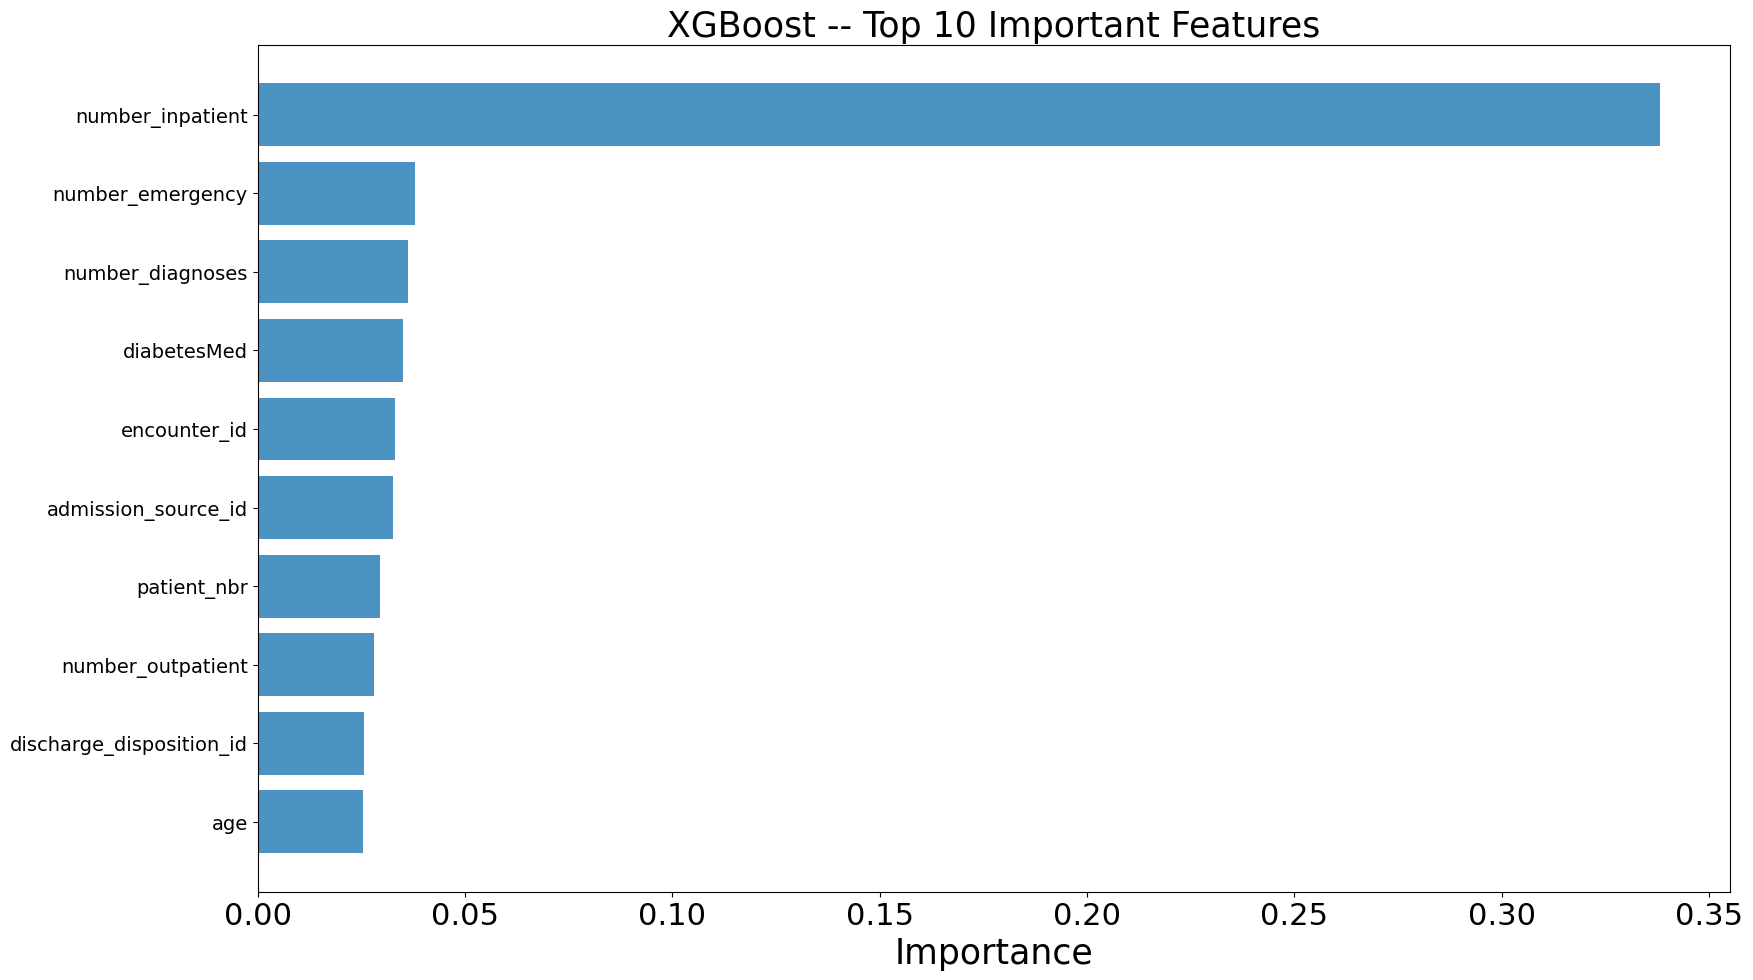

In [50]:

feature_names = X_train.columns
feature_imports = best_model.feature_importances_
most_imp_features = pd.DataFrame([f for f in zip(feature_names, feature_imports)],
                                 columns=["Feature", "Importance"]).nlargest(10, "Importance")
most_imp_features.sort_values(by="Importance", inplace=True)
plt.figure(figsize=(19, 11))
plt.rc('xtick',labelsize=22)
plt.barh(range(len(most_imp_features)), most_imp_features.Importance, align='center', alpha=0.8)
plt.yticks(range(len(most_imp_features)), most_imp_features.Feature, fontsize=14)
plt.xlabel('Importance', fontsize=25)
plt.title('XGBoost -- Top 10 Important Features', fontsize=25)

In [53]:
def prediction(patient_data):
    
    # Convert the Series to a NumPy array
    patient_data_array = np.array(patient_data)

    # Reshape the array
    patient_data_reshaped = patient_data_array.reshape(1, -1)
    
    # Make the prediction
    pred = best_model.predict(patient_data_reshaped)
    return pred

In [54]:
fila = df.iloc[12].drop('readmitted')

In [55]:
prediction(fila)

array([1])